### In this notebook, we show how to get all the input data for electrolyte for the col-solvent. Instead of showing parameters in mole fraction base (y_e), we use concentration base (c_e) here so that it is ready to put into PyBaMM.

#### We adapt Case-3 in determing the parameters: we assume t_0plus, X_oe=X_eo=0 are known and derive Xi_tilde, X_ee and X_oo (o refers to EC here)

In [1]:
import numpy as np; import pandas as pd; 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib as mpl; 
from openpyxl import load_workbook
import sympy as sy; from sympy import symbols,diff
fs=11; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
import os

In [2]:
BasicPath = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/Input/")
Target  = 'Plot_Para/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)
Path_Fig_save = BasicPath + Target

#### Fit density $ \rho $ as a function of $ c_\mathrm{EC} $ and $ c_\mathrm{e} $, then substitube into the following equations to get the three partial molar volume $ \bar{V}_\mathrm{e} $, $ \bar{V}_\mathrm{EC} $, $ \bar{V}_\mathrm{0} $ and total concentration $ c_\mathrm{T} $.

##### Fit ρ as a linear combination of c_EC and c_e:   $$ ρ = ρ₀ + ρ₁ c_{\text{EC}} + ρ₂ c_\text{e} \tag{S20} $$

##### According to Jung 2023, the three partial molar volumes are $$ \bar{V}_0 = \frac{\bar{m}_0}{\rho - c_{\text{EC}} \frac{\partial \rho}{\partial c_{\text{EC}}} - c_e \frac{\partial \rho}{\partial c_e}} = \frac{\bar{m}_0}{\rho_0} \tag{S23} $$ $$ \bar{V}_{\text{EC}} = \frac{\bar{m}_{\text{EC}} - \frac{\partial \rho}{\partial c_{\text{EC}}}}{\rho - c_{\text{EC}} \frac{\partial \rho}{\partial c_{\text{EC}}} - c_e \frac{\partial \rho}{\partial c_e}} = \frac{\bar{m}_{\text{EC}} - \rho_1}{\rho_0} \tag{S24} $$ $$ \bar{V}_\mathrm{e} = \frac{\bar{m}_\mathrm{e} - \frac{\partial \rho}{\partial c_\mathrm{e}}}{\rho - c_{\text{EC}} \frac{\partial \rho}{\partial c_{\text{EC}}} - c_\mathrm{e} \frac{\partial \rho}{\partial c_\mathrm{e}}} = \frac{\bar{m}_\mathrm{e} - \rho_2}{\rho_0} \tag{S25} $$

##### Then: $$ c_\mathrm{T} = \frac{\rho - (\overline{m}_\mathrm{EC} - \overline{m}_\mathrm{0}) c_\mathrm{EC} + (\overline{m}_\mathrm{e} - 2\overline{m}_\mathrm{0}) c_\mathrm{e}}{\overline{m}_\mathrm{0}} \tag{S22} $$


In [3]:
# Get Fun_rho
rho_0 = 1006.1; rho_1 = 0.02235185918895445; rho_2 = 0.10065156540490541
def Fun_rho(c_e, c_EC):
    return rho_0  + rho_1 * c_EC + rho_2 * c_e
# Three partial molar volume - Eq. (S23)~(S25)
m_bar_EC = 88.062*1e-3 #   kg/mol
m_bar_0  = 104.105*1e-3 #   kg/mol
m_bar_e  = 151.905*1e-3 #   kg/mol
V_bar_0  = m_bar_0 / rho_0
V_bar_EC = (m_bar_EC - rho_1) / rho_0
V_bar_e = (m_bar_e - rho_2) / rho_0
print("Partial molar volumes are:")
print(f"EMC: {V_bar_0:.4e} m3/mol")
print(f"EC: {V_bar_EC:.4e} m3/mol")
print(f"LiPF6: {V_bar_e:.4e} m3/mol")
# Total concentration c_T - Eq. (S22)
def Fun_c_T(c_e, c_EC):
    b = (
        (m_bar_EC-m_bar_0) * c_EC 
        + (m_bar_e-2*m_bar_0)*c_e  ) 
    c_T= (Fun_rho(c_e, c_EC ) - b) / m_bar_0
    return c_T

Partial molar volumes are:
EMC: 1.0347e-04 m3/mol
EC: 6.5312e-05 m3/mol
LiPF6: 5.0943e-05 m3/mol


#### Now we find values for the cation transference number $ t_+^0 $ in Wang 2021: 
$$
t_+^0 = 0.4107 - 1.487 y_e + 2.547 y_e^2
$$


Ref: A.A. Wang, A.B. Gunnarsdottir, J. Fawdon, M. Pasta, C.P. Grey, C.W. Monroe, Acs Energy Letters, 6 (2021) 3086-3095.

In [4]:
# cation transference number 


def Fun_t_0plus_Wang2021_yBased(y_e,y_EC):
    return 0.4107-1.487*y_e+2.547*y_e**2

def Fun_t_0plus_Wang2021(c_e,c_EC):
    c_T = Fun_c_T(c_e, c_EC)
    y_e = c_e / c_T
    return 0.4107-1.487*y_e+2.547*y_e**2


#### Measured liquid junction potential (LJP) and its derivative.

##### $ \Delta U $ as function of $ y_\mathrm{e} $ in Jung Eq. (13): $$ \Delta U(y_e) = \frac{RT}{F} \left(1.491 \cdot \ln(y_e) + 3.007 - 8.168 \cdot y_e + 199.6 \cdot (y_e)^2\right) $$

##### $ \Delta U $ as function of $ y_\mathrm{e} $ and $ y_\mathrm{EC} $ (Eq. (17), (14), (18), (19) in Jung 2023): $$ \Delta U(y_\mathrm{EC}, y_\mathrm{e}) = \left(1 - \frac{y_\mathrm{EC}}{1 - 2y_\mathrm{e}}\right) \Delta U_{1:0}(y_\mathrm{e}) + \frac{y_\mathrm{EC}}{1 - 2y_\mathrm{e}} \Delta U_{0:1}(y_\mathrm{e}) + \Delta U_\mathrm{ex}(y_\mathrm{EC}, y_\mathrm{e}) $$      $$ \Delta U_{1:0}(y_\mathrm{e}) = \frac{RT}{F} \left(7.167 - 43.16(y_\mathrm{e})^{0.5} + 185.4(y_\mathrm{e}) - 402.4(y_\mathrm{e})^{1.5} + 236.9(y_\mathrm{e})^2 + 253.7(y_\mathrm{e})^{2.5} - 408.1(y_\mathrm{e})^3 + 2509(y_\mathrm{e})^{3.5} - 2886(y_\mathrm{e})^4.5 + 1.174 \ln(y_\mathrm{e})\right) $$  $$ \Delta U_{0:1}(y_\mathrm{e}) = \frac{RT}{F} \left(3.024 \ln(y_\mathrm{e}) + 8.233 - 88.12(y_\mathrm{e}) + 477.9(y_\mathrm{e})^2\right) $$ $$ \Delta U_\mathrm{ex}(y_\mathrm{EC}, y_\mathrm{e}) = \frac{RT}{F} \left( (y_\mathrm{EC} - y_\mathrm{EC}^2 - 2y_\mathrm{e} y_\mathrm{EC}) \cdot (32.2 - 37.99y_\mathrm{EC} - 44.8(1 - y_\mathrm{EC} - 2y_\mathrm{e})) \right) $$

In [5]:
def LJP_1_Specie_y_np(y_e,T):   # ALL IN ISO Units, range limit: 0< y_e <= 0.15 
    # Eq. (13):
    R = 8.31446261815324
    F = 96485.3321
    aln = 1.491; a0 = 3.007; a1 = -8.168; a2 = 199.6
    delta_U = R*T/F*(
        aln * np.log(y_e) + a0 + a1*y_e  + a2 * y_e**2
    )
    return delta_U

def LJP_2_Species_y_np(y_e,y_EC):
    T = 298.15;
    # y0 = c0/cT;   y_e = ce/cT;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80
    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*y_e**0.5 + 185.4*y_e - 402.4*y_e**1.5 
        + 236.9*y_e**2 + 253.7*y_e**2.5 - 408.1*y_e**3 
        + 2509*y_e**3.5 - 2886*y_e**4.5 + 1.174*np.log(y_e) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*np.log(y_e) + b0 + b1*y_e + b2*y_e**2
    )
    # Eq. (19):
    delta_U_ex = R*T/F*  y_EC  * (
        (1-y_EC-2*y_e) * (
        p + q*y_EC + r*(1-y_EC-2*y_e)
        )
    )
    # Eq. (17):
    delta_U = (
        ( 1 - y_EC/(1-2*y_e)  ) * delta_U_1to0 
        + y_EC/(1-2*y_e) * delta_U_0to1 
        + delta_U_ex
    )
    return delta_U # units: V

def LJP_2_Species_y_sy(y_e,y_EC):
    T = 298.15;
    # y0 = c0/cT;   y_e = ce/cT;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80
    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*y_e**0.5 + 185.4*y_e - 402.4*y_e**1.5 
        + 236.9*y_e**2 + 253.7*y_e**2.5 - 408.1*y_e**3 
        + 2509*y_e**3.5 - 2886*y_e**4.5 + 1.174*sy.log(y_e) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*sy.log(y_e) + b0 + b1*y_e + b2*y_e**2
    )
    # Eq. (19):
    delta_U_ex = R*T/F*  y_EC  * (
        (1-y_EC-2*y_e) * (
        p + q*y_EC + r*(1-y_EC-2*y_e)
        )
    )
    # Eq. (17):
    delta_U = (
        ( 1 - y_EC/(1-2*y_e)  ) * delta_U_1to0 
        + y_EC/(1-2*y_e) * delta_U_0to1 
        + delta_U_ex
    )
    return delta_U # units: V


/tmp/ipykernel_11462/906180253.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("copper", len(Cases))


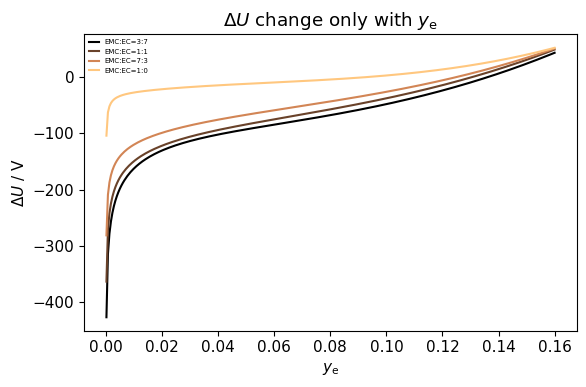

In [6]:
# plot delta_U as one species
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Y_e = np.linspace(1E-4,0.16,300).tolist(); T=298.75
delta_U_1Species_1 = []; delta_U_1Species_2 = []; 
for y_e in Y_e:
    delta_U_1Species_2.append(LJP_1_Specie_y_np(y_e,T))
fig, ax = plt.subplots(figsize=(6, 4), tight_layout='constrained')
Cases = ["EMC:EC=3:7", "EMC:EC=1:1", "EMC:EC=7:3", "EMC:EC=1:0"]
cop2 = mpl.cm.get_cmap("copper", len(Cases))
Ratios = [7/10, 1/2, 3/10, 0]
for i in range(len(Cases)):
    x_plot = Y_e
    y_plot = []
    for y_e in Y_e:
        y_EC = (1-2*y_e) * Ratios[i]
        y_plot.append( LJP_2_Species_y_np(y_e, y_EC)*1e3  ) 
    ax.plot(x_plot, y_plot,"-",color=cop2(i),label=Cases[i])

#ax.plot(Y_e,np.array(delta_U_1Species_2)*1e3,'--',label="EMC:EC=1:1-single")
ax.legend(prop={'family':'DejaVu Sans','size':fs-6},
    frameon=False,markerscale=1,borderpad=0.2,
    handlelength=1.5,columnspacing=1)
ax.set_ylabel("$\Delta U$ / V")
ax.set_title("$\Delta U$ change only with $y_\mathrm{e}$")
ax.set_xlabel("$y_\mathrm{e}$")
Save_fig = True 
if Save_fig:
    plt.savefig(Path_Fig_save + "/" +  f"Jung 2023 Fig. 1 LJP change with y_e.png", dpi=600)
    plt.savefig(Path_Fig_save + "/" +  f"Jung 2023 Fig. 1 LJP change with y_e.svg") 


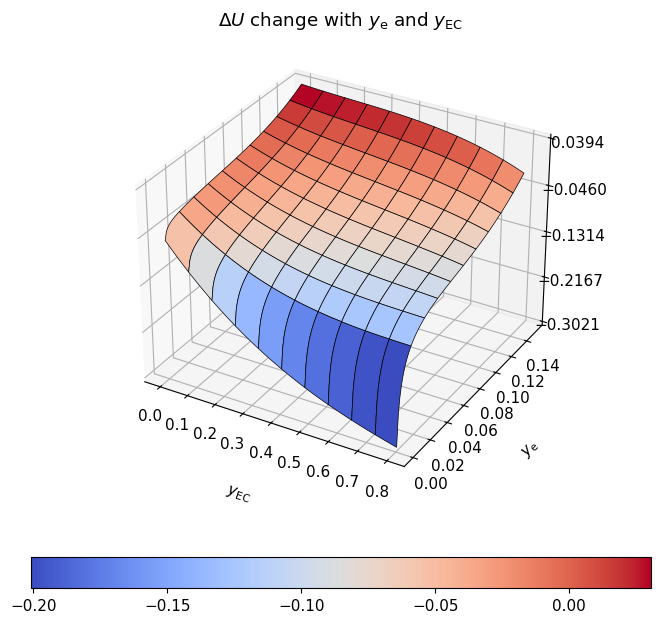

In [7]:
# Plot LJP 2D
Y_e = np.linspace(1E-3,0.15,100).tolist(); 
Y_o = np.linspace(1E-3,0.80,100).tolist(); 
Y_o, Y_e = np.meshgrid(Y_o, Y_e)
delta_U2 = LJP_2_Species_y_np(Y_e,Y_o)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(20, 8))
# Plot the surface.
surf = ax.plot_surface(
    Y_o, Y_e, delta_U2,
    rstride=10, cstride=10, cmap=cm.coolwarm, # Adjusting rstride and cstride for less density
    linewidth=0.5, edgecolor='k', antialiased=True) 

ax.zaxis.set_major_locator(LinearLocator(5))

ax.set_zlabel("$\Delta U$ / V")
ax.set_title("$\Delta U$ change with $y_\mathrm{e}$ and $y_\mathrm{EC}$")
ax.set_ylabel("$y_\mathrm{e}$",)
ax.set_xlabel("$y_\mathrm{EC}$")

ax.xaxis.labelpad = 15  # Adjust the x-axis label position
ax.yaxis.labelpad = 15  # Adjust the y-axis label position
ax.zaxis.labelpad = 40  # Adjust the z-axis label position

# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:1.f}')

# Add a color bar which maps values to colors.
cbar = fig.colorbar(surf, orientation='horizontal', pad=0.1, shrink=0.4)
if Save_fig:
    plt.savefig(Path_Fig_save + "/" +  f"Jung 2023 Fig. 3 LJP change with y_e and y_EC.png", dpi=600)
    plt.savefig(Path_Fig_save + "/" +  f"Jung 2023 Fig. 3 LJP change with y_e and y_EC.svg") 

In [8]:
x,y=symbols("x y",real=True)
d_deltaU_dye = diff(LJP_2_Species_y_sy(x,y),x) # x: y_e; y: y_EC
print(d_deltaU_dye)

2.30205508980545*y*(-2*x - y + 1) - 0.0513851582545859*y*(89.6*x + 6.81*y - 12.6) + y*(24.5569671298666*x - 2.26403007269705 + 0.0776943592809339/x)/(1 - 2*x) + 2*y*(12.2784835649333*x**2 - 2.26403007269705*x + 0.0776943592809339*log(x) + 0.211527003955003)/(1 - 2*x)**2 - 2*y*(-1.10889171513396*x**0.5 - 10.4851415418483*x**3 + 6.0865719952557*x**2 + 4.76340417020011*x - 10.3386938408227*x**1.5 + 6.51820732459422*x**2.5 + 64.462681030378*x**3.5 - 74.1487833613674*x**4.5 + 0.0301630878954419*log(x) + 0.184138714605309)/(1 - 2*x)**2 + (-y/(1 - 2*x) + 1)*(-0.554445857566982/x**0.5 - 15.508040761234*x**0.5 - 31.4554246255448*x**2 + 12.1731439905114*x + 16.2955183114856*x**1.5 + 225.619383606323*x**2.5 - 333.669525126154*x**3.5 + 4.76340417020011 + 0.0301630878954419/x)


/tmp/ipykernel_11462/1220898840.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap  = mpl.cm.get_cmap("cool", len(y_e_list))
/tmp/ipykernel_11462/1220898840.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("copper", len(Cases))


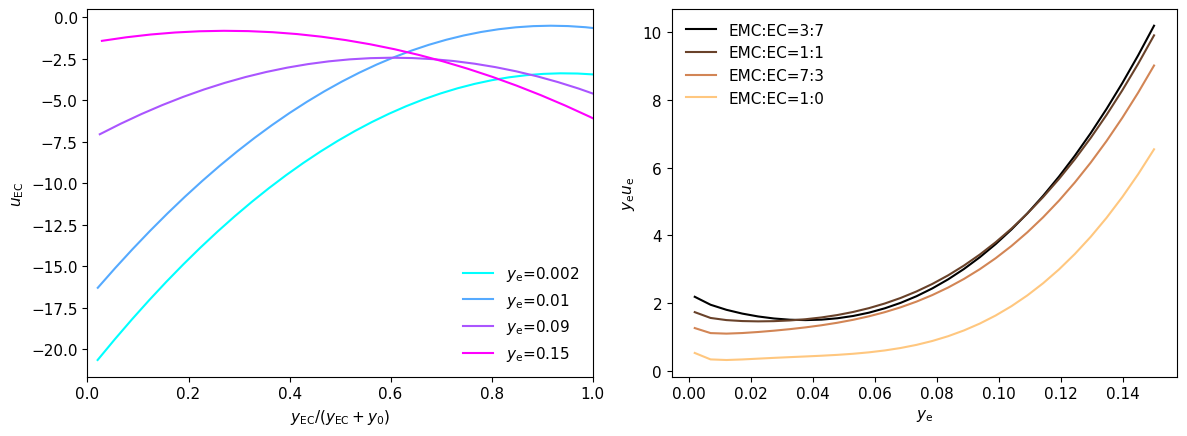

In [9]:
# To ensure we have the right derivative of LJP, we now compare with Fig. 5 and 6 in Jung 2023 paper
def Fun_u_EC(y_e, y_EC): # Eq. (12) in Jung 2023 paper
    T  = 298.15
    # constant first
    R = 8.31446261815324; F = 96485.3321
    # x,y=symbols("x y",real=True)
    # d_deltaU_dyEC = diff(LJP_2_Species_y_sy(x,y),y) # x: y_e; y: y_EC
    d_deltaU_dyEC = 0.174966463856865*y_EC*(-2*y_e - y_EC + 1) - 0.0256925791272929*y_EC*(89.6*y_e + 6.81*y_EC - 12.6) + 0.0256925791272929*(-2*y_e - y_EC + 1)*(89.6*y_e + 6.81*y_EC - 12.6) + (12.2784835649333*y_e**2 - 2.26403007269705*y_e + 0.0776943592809339*np.log(y_e) + 0.211527003955003)/(1 - 2*y_e) - (-1.10889171513396*y_e**0.5 - 10.4851415418483*y_e**3 + 6.0865719952557*y_e**2 + 4.76340417020011*y_e - 10.3386938408227*y_e**1.5 + 6.51820732459422*y_e**2.5 + 64.462681030378*y_e**3.5 - 74.1487833613674*y_e**4.5 + 0.0301630878954419*np.log(y_e) + 0.184138714605309)/(1 - 2*y_e)

    u_EC = F/(R*T) * d_deltaU_dyEC   # .subs({x:y_e,  y:y_EC })
    return u_EC

def Fun_y_e_u_e(y_e, y_EC): # Eq. (12) in Jung 2023 paper
    T  = 298.15
    # constant first
    R = 8.31446261815324; F = 96485.3321
    # x,y=symbols("x y",real=True)
    # d_deltaU_dye = diff(LJP_2_Species_y_sy(x,y),x) # x: y_e; y: y_EC
    d_deltaU_dye = 2.30205508980545*y_EC*(-2*y_e - y_EC + 1) - 0.0513851582545859*y_EC*(89.6*y_e + 6.81*y_EC - 12.6) + y_EC*(24.5569671298666*y_e - 2.26403007269705 + 0.0776943592809339/y_e)/(1 - 2*y_e) + 2*y_EC*(12.2784835649333*y_e**2 - 2.26403007269705*y_e + 0.0776943592809339*np.log(y_e) + 0.211527003955003)/(1 - 2*y_e)**2 - 2*y_EC*(-1.10889171513396*y_e**0.5 - 10.4851415418483*y_e**3 + 6.0865719952557*y_e**2 + 4.76340417020011*y_e - 10.3386938408227*y_e**1.5 + 6.51820732459422*y_e**2.5 + 64.462681030378*y_e**3.5 - 74.1487833613674*y_e**4.5 + 0.0301630878954419*np.log(y_e) + 0.184138714605309)/(1 - 2*y_e)**2 + (-y_EC/(1 - 2*y_e) + 1)*(-0.554445857566982/y_e**0.5 - 15.508040761234*y_e**0.5 - 31.4554246255448*y_e**2 + 12.1731439905114*y_e + 16.2955183114856*y_e**1.5 + 225.619383606323*y_e**2.5 - 333.669525126154*y_e**3.5 + 4.76340417020011 + 0.0301630878954419/y_e)

    u_e = F/(R*T) * d_deltaU_dye    # .subs({x:y_e,  y:y_EC })
    return u_e * y_e



fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True)
# plot the first one:
y_e_list = [0.002, 0.01, 0.09, 0.15]
T=298.75
y_EC_array = np.linspace(0.02,1.00,30)
cmap  = mpl.cm.get_cmap("cool", len(y_e_list)) 

for i in range(len(y_e_list)):
    x_plot = y_EC_array / (1-2*y_e_list[i])
    y_plot = []
    for y_EC in y_EC_array:
        y_plot.append(Fun_u_EC(y_e_list[i], y_EC))
    axs[0].plot(x_plot, y_plot,"-",color=cmap(i),label=r"$y_\mathrm{e}$=" + f"{y_e_list[i]}")
axs[0].set_xlim(0,1)
axs[0].set_xlabel("$y_\mathrm{EC} / (y_\mathrm{EC}+y_\mathrm{0})$")
axs[0].set_ylabel("$u_\mathrm{EC}$")
axs[0].legend(frameon=False)
# Plot the second one:
y_e_array = np.linspace(0.002,0.15,30)
# EMC:EC=3:7, 1:1, 7:3, 1:0
Cases = ["EMC:EC=3:7", "EMC:EC=1:1", "EMC:EC=7:3", "EMC:EC=1:0"]
cop2 = mpl.cm.get_cmap("copper", len(Cases))
Ratios = [7/10, 1/2, 3/10, 0]
for i in range(len(Cases)):
    x_plot = y_e_array
    y_plot = []
    for y_e in y_e_array:
        y_EC = (1-2*y_e) * Ratios[i]
        y_plot.append( Fun_y_e_u_e(y_e, y_EC)  ) 
    axs[1].plot(x_plot, y_plot,"-",color=cop2(i),label=Cases[i])
axs[1].set_ylabel("$y_\mathrm{e}u_\mathrm{e}$")
axs[1].set_xlabel("$y_\mathrm{e}$")
axs[1].legend(frameon=False)
if Save_fig:
    plt.savefig(Path_Fig_save + "/" +  f"Jung 2023 Fig. 5 and 6 - Junction Coefficients.png", dpi=600)
    plt.savefig(Path_Fig_save + "/" +  f"Jung 2023 Fig. 5 and 6 - Junction Coefficients.svg") 

##### Now we need to get  $$ \frac{\partial \Delta U}{\partial c_\mathrm{e}}, \frac{\partial \Delta U}{\partial c_\mathrm{EC}} $$
##### To start with, we need to change input variables from y_i to c_i, then re-defined all previous function in terms of sy instead of np. Then instead of manually derive, we just use the sy.diff function


In [10]:
import sympy as sy; from sympy import symbols,diff
def LJP_1_Specie_sy(c_e):   # ALL IN ISO Units, range limit: 0< y_e <= 0.15 
    T = 298.15
    c_EC = 6250
    c_T = Fun_c_T(c_e, c_EC)
    y_e = c_e / c_T
    # Eq. (13):
    R = 8.31446261815324
    F = 96485.3321
    aln = 1.491; a0 = 3.007; a1 = -8.168; a2 = 199.6
    delta_U = R*T/F*(
        aln * sy.log(y_e) + a0 + a1*y_e  + a2 * y_e**2
    )
    return delta_U

def LJP_2_Species_sy(c_e,c_EC):
    T = 298.15
    c_T = Fun_c_T(c_e, c_EC)
    y_EC = c_EC / c_T;   y_e = c_e / c_T;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80
    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*y_e**0.5 + 185.4*y_e - 402.4*y_e**1.5 
        + 236.9*y_e**2 + 253.7*y_e**2.5 - 408.1*y_e**3 
        + 2509*y_e**3.5 - 2886*y_e**4.5 + 1.174*sy.log(y_e) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*sy.log(y_e) + b0 + b1*y_e + b2*y_e**2
    )
    # Eq. (19):
    delta_U_ex = R*T/F*  y_EC  * (
        (1-y_EC-2*y_e) * (
        p + q*y_EC + r*(1-y_EC-2*y_e)
        )
    )
    # Eq. (17):
    delta_U = (
        ( 1 - y_EC/(1-2*y_e)  ) * delta_U_1to0 
        + y_EC/(1-2*y_e) * delta_U_0to1 
        + delta_U_ex
    )
    return delta_U # units: V
# Get derivative
x,y=symbols("x y",real=True)
T = 298.15
dLJP_2_Species_dc_EC_r = diff(LJP_2_Species_sy(x,y),y)   # x: c_e; y: c_EC
dLJP_2_Species_dc_e_r = diff(LJP_2_Species_sy(x,y),x)    # x: c_e; y: c_EC
dLJP_1_Specie_dc_e_r = diff(LJP_1_Specie_sy(x),x)            # x: c_e

##### However, the equations contains sy.log, which takes quite a while to operate. To make it faster, we now need to substitube it with np.log, when using in pybamm, need to change to pybamm.log

In [11]:
print(dLJP_2_Species_dc_EC_r,"\n\n")
print(dLJP_2_Species_dc_e_r,"\n\n")
print(dLJP_1_Specie_dc_e_r,"\n\n")

-7.89754965808084e-9*x*y*(1.31463627670492e-7*x**2/(0.000156004935299578*x + 3.81620705585473e-5*y + 1)**2 - 2.26403007269705*x/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266) + 0.0776943592809339*log(x/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266)) + 0.211527003955003)/((-2*x/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266) + 1)**2*(0.000156004935299578*x + 3.81620705585473e-5*y + 1)**2*(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266)) + 0.0256925791272929*y*(-3.53810224682022e-7*x/(0.000156004935299578*x + 3.81620705585473e-5*y + 1)**2 - 2.68911565857653e-8*y/(0.000156004935299578*x + 3.81620705585473e-5*y + 1)**2 + 6.81/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266))*(-2*x/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266) - y/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266) + 1)/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266) + 0.0256925791272929*y*(7.89754965808084e-9*x/(0.

In [12]:
# initial
def dLJP_2_Species_dc_EC_np(c_e,c_EC):
    return -7.89754965808084e-9*c_e*c_EC*(1.31463627670492e-7*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.211527003955003)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)**2*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.0256925791272929*c_EC*(-3.53810224682022e-7*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.68911565857653e-8*c_EC/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 6.81/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0256925791272929*c_EC*(7.89754965808084e-9*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 3.94877482904042e-9*c_EC/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 1/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(89.6*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 6.81*c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 12.6)/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 1.01454209750984e-10*c_EC*(-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(89.6*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 6.81*c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 12.6)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + c_EC*(-1.00338484700878e-11*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 + 8.94014496325669e-9*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 3.06797530286975e-10*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) - 3.94877482904042e-9*c_EC*(1.31463627670492e-7*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.211527003955003)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2) + (-c_EC/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 1)*(1.32989943307757e-15*c_e**3/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**4 - 4.97388303528732e-12*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 - 1.88096104878324e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 2.18938184642623e-9*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**0.5*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 6.12377610056938e-8*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**1.5*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 6.43473325345614e-8*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**2.5*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 8.90920142928264e-7*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**3.5*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 1.31758582203603e-6*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**4.5*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 1.19107242247655e-10*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2) + (7.89754965808084e-9*c_e*c_EC/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)**2*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 3.94877482904042e-9*c_EC/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2) - 1/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)))*(-1.16162410618092e-11*c_e**3/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 + 6.51678874139771e-8*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 4.76340417020011*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 1.10889171513396*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**0.5 - 10.3386938408227*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**1.5 + 6.51820732459422*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**2.5 + 64.462681030378*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**3.5 - 74.1487833613674*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**4.5 + 0.0301630878954419*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.184138714605309) + 0.0256925791272929*(-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(89.6*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 6.81*c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 12.6)/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + (1.31463627670492e-7*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.211527003955003)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))
def dLJP_2_Species_dc_e_np(c_e,c_EC):
    return c_EC*(-3.22848499937632e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 2/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.31463627670492e-7*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.211527003955003)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)**2*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.0256925791272929*c_EC*(-1.44636127972059e-6*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 1.09929914228764e-7*c_EC/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 89.6/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0256925791272929*c_EC*(3.22848499937632e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 1.61424249968816e-8*c_EC/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(89.6*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 6.81*c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 12.6)/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 4.14740531538772e-10*c_EC*(-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(89.6*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 6.81*c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 12.6)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + c_EC*(-4.1017949457966e-11*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 + 2.99474190980181e-7*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*(-1.61424249968816e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 1/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) - 1.61424249968816e-8*c_EC*(1.31463627670492e-7*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.211527003955003)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2) + (-c_EC/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 1)*(5.43657280581555e-15*c_e**3/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**4 - 5.5181747304683e-11*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 + 5.34428802806659e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 4.76340417020011/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 1.10889171513396*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**0.5*(-8.07121249844079e-9*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 0.5/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e - 10.3386938408227*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**1.5*(-2.42136374953224e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 1.5/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e + 6.51820732459422*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**2.5*(-4.0356062492204e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 2.5/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e + 64.462681030378*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**3.5*(-5.64984874890856e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 3.5/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e - 74.1487833613674*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**4.5*(-7.26409124859671e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 4.5/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e + 0.0301630878954419*(-1.61424249968816e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 1/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e) + (-c_EC*(-3.22848499937632e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 2/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)**2*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 1.61424249968816e-8*c_EC/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2))*(-1.16162410618092e-11*c_e**3/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 + 6.51678874139771e-8*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 4.76340417020011*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 1.10889171513396*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**0.5 - 10.3386938408227*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**1.5 + 6.51820732459422*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**2.5 + 64.462681030378*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**3.5 - 74.1487833613674*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**4.5 + 0.0301630878954419*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.184138714605309)
def dLJP_1_Specie_dc_e_np(c_e):
    return -9.01770046675714e-12*c_e**2/(0.000125961489893485*c_e + 1)**3 + 7.37994000756151e-8*c_e/(0.000125961489893485*c_e + 1)**2 - 0.209856986311729/(1.50767557182561*c_e + 11969.3373990775) + 0.0383076354787938*(1.50767557182561*c_e + 11969.3373990775)*(-1.05236811106346e-8*c_e/(0.000125961489893485*c_e + 1)**2 + 1/(1.50767557182561*c_e + 11969.3373990775))/c_e


In [13]:
print(dLJP_1_Specie_dc_e_np(1500))
print(dLJP_2_Species_dc_e_np(1500,6209.49))
print(dLJP_2_Species_dc_EC_np(1500,6209.49))

7.297182865056465e-05
6.58672225092772e-05
-6.569284897476549e-06


In [14]:
# Substitube in some values and plot, to confirm that the substitution is correct (sy.log -> np.log)
c_EC_1_specie = 6209.49         # When c_e=1000 mol/m3, c_EC=5622.86, c_T=13245.72 mol/m3
C_e = np.linspace(100,2.5E3,300).tolist(); T=298.75
C_EC = np.linspace(1E3,1E4,300).tolist(); 
dLJP_1_Specie_dc_e_r_sub=[]
dLJP_2_Species_dc_e_r_sub=[]
dLJP_2_Species_dc_EC_r_sub=[]
dLJP_1_Specie_dc_e_np_sub=[]
dLJP_2_Species_dc_e_np_sub=[]
dLJP_2_Species_dc_EC_np_sub=[]
for ce in C_e:
    dLJP_1_Specie_dc_e_r_sub.append(dLJP_1_Specie_dc_e_r.subs({x:ce}))
    dLJP_1_Specie_dc_e_np_sub.append(dLJP_1_Specie_dc_e_np(ce))
    dLJP_2_Species_dc_e_r_sub.append(dLJP_2_Species_dc_e_r.subs({x:ce,y:c_EC_1_specie}))
    dLJP_2_Species_dc_e_np_sub.append(dLJP_2_Species_dc_e_np(ce,c_EC_1_specie))
for cec in C_EC:
    dLJP_2_Species_dc_EC_r_sub.append(dLJP_2_Species_dc_EC_r.subs({x:1e3,y:cec}))
    dLJP_2_Species_dc_EC_np_sub.append(dLJP_2_Species_dc_EC_np(1e3,cec))


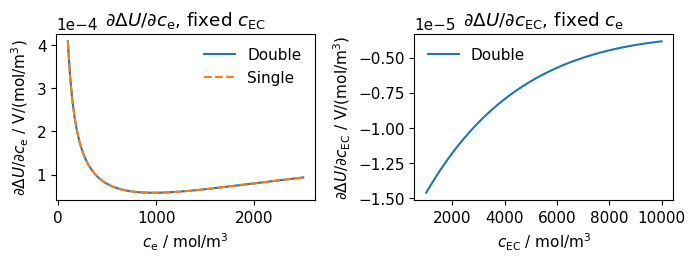

In [15]:
# plot
fs=11; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
fig, axs = plt.subplots(1,2, figsize=(18/2.54,7/2.54),tight_layout=True)
axs[0].plot(C_e,np.array(dLJP_2_Species_dc_e_np_sub),"-",label="Double")
axs[0].plot(C_e,np.array(dLJP_2_Species_dc_e_np_sub),"--",label="Single")
#axs[0].plot(C_e, np.array(dLJP_1_Specie_dc_e_np_sub),"--",label="Single")
#axs[0].plot(C_e,np.array(dLJP_2_Species_dc_e_r_sub),"-",label="2 species sy")
#axs[1].plot(C_EC,np.array(dLJP_2_Species_dc_EC_r_sub),"-",label="2 species sy")
axs[1].plot(C_EC,np.array(dLJP_2_Species_dc_EC_np_sub),"-",label="Double")
for i in range(2): 
    axs[i].legend(loc='best',frameon=False)  
#axs[0].set_ylabel(r'$\frac{\partial \Delta U}{\partial c_\mathrm{e}}$ / V')
#axs[0].set_title(r'$\frac{\partial \Delta U}{\partial c_\mathrm{e}}$, fixed $c_\mathrm{EC}$')
axs[0].set_ylabel(r'$\partial \Delta U / \partial c_\mathrm{e}$ / $\mathrm{V/(mol/m^3)}$')
axs[0].set_title(r'$\partial \Delta U / \partial c_\mathrm{e}$, fixed $c_\mathrm{EC}$')
axs[1].set_ylabel(r'$\partial \Delta U / \partial c_\mathrm{EC}$ / $\mathrm{V/(mol/m^3)}$')
axs[1].set_title(r'$\partial \Delta U / \partial c_\mathrm{EC}$, fixed $c_\mathrm{e}$')
axs[0].set_xlabel(r"$c_\mathrm{e}$ / mol/$\mathrm{m}^3$")
axs[1].set_xlabel(r"$c_\mathrm{EC}$ / mol/$\mathrm{m}^3$")
for i in range(2):
    axs[i].ticklabel_format( 
        axis='y', style='sci',scilimits=[-0.01,0.01], 
        useOffset=None, useLocale=None, useMathText=None)

Save_fig = True
if Save_fig:
    plt.savefig(Path_Fig_save + "/" +  f"Critical input dLJP_dc change with y_e or y_EC.png", dpi=600)
    plt.savefig(Path_Fig_save + "/" +  f"Critical input dLJP_dc change with y_e or y_EC.svg") 

#### Based on the discussion in this work, we can now determine the four thermodynamic factors $ X_{ij} $ and electro-osmotic coefficient of EC $ \widetilde{\Xi} $ . We adapt case-3:

##### We assume $ X_\mathrm{e,EC}=0 $, $ X_\mathrm{EC,e}=0 $ and $ t_+^0 $ are known, then:
$$
\widetilde{\Xi} = \frac{-u_{\mathrm{EC}}}{1 + X_{(\mathrm{EC,EC})}} \tag{39}
$$

$$
X_{\mathrm{ee}} = \frac{u_{\mathrm{e}} y_{\mathrm{e}}}{1 - t_+^0} - 2 \tag{40}
$$

$$
X_{(\mathrm{EC,EC})} = \frac{1}{2} X_{\mathrm{ee}} \tag{41}


In [16]:
def Fun_X_e_e_yBased(y_e,y_EC):
    u_e_y_e = Fun_y_e_u_e(y_e, y_EC)
    t_0plus = Fun_t_0plus_Wang2021_yBased(y_e,y_EC)
    return u_e_y_e / (1-t_0plus) - 2
def Fun_X_EC_EC_yBased(y_e,y_EC):
    return 0.5* Fun_X_e_e_yBased(y_e,y_EC)
def Fun_Xi_tidle_yBased(y_e,y_EC):
    u_EC = Fun_u_EC(y_e, y_EC)
    X_oo = Fun_X_EC_EC_yBased(y_e,y_EC)
    Xi_tilde = - u_EC / (1+X_oo)
    return Xi_tilde
# CHANGE TO c_ based
def Fun_X_e_e(c_e,c_EC):
    c_T = Fun_c_T(c_e, c_EC)
    y_e = c_e / c_T
    y_EC =c_EC/ c_T
    u_e_y_e = Fun_y_e_u_e(y_e, y_EC)
    t_0plus = Fun_t_0plus_Wang2021_yBased(y_e,y_EC)
    return u_e_y_e / (1-t_0plus) - 2
def Fun_X_EC_EC(c_e,c_EC):
    c_T = Fun_c_T(c_e, c_EC)
    y_e = c_e / c_T
    y_EC =c_EC/ c_T
    return 0.5* Fun_X_e_e_yBased(y_e,y_EC)
def Fun_Xi_tidle(c_e,c_EC):
    c_T = Fun_c_T(c_e, c_EC)
    y_e = c_e / c_T
    y_EC =c_EC/ c_T
    u_EC = Fun_u_EC(y_e, y_EC)
    X_oo = Fun_X_EC_EC_yBased(y_e,y_EC)
    Xi_tilde = - u_EC / (1+X_oo)
    return Xi_tilde

/tmp/ipykernel_11462/2300260811.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("cool", len(c_EC_List))


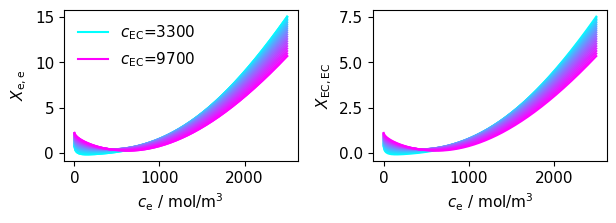

In [17]:
# Have a look at how the thermodynamic factors look like:
C_e = np.linspace(1,2.5E3,300); T=298.75
c_EC_List = np.linspace(3300,9700,20).tolist()
cmap = mpl.cm.get_cmap("cool", len(c_EC_List)) 
def Plot_X_ee_EC():
    fig, axs = plt.subplots(1,2, figsize=(16/2.54,6/2.54),tight_layout=True)
    axs[0].plot(C_e, Fun_X_e_e(C_e,  c_EC_List[0] ),"-",color=cmap(0), label="$c_\mathrm{EC}$=" + f"3300")
    axs[0].plot(C_e, Fun_X_e_e(C_e,  c_EC_List[-1]),"-",color=cmap(19),label="$c_\mathrm{EC}$=" + f"9700")
    for i in range(len(c_EC_List)):
        axs[0].plot(C_e, Fun_X_e_e(C_e,  c_EC_List[i] ),"-",color=cmap(i))
        axs[1].plot(C_e, Fun_X_EC_EC(C_e, c_EC_List[i] ),"-",color=cmap(i))
    for i in range(2): 
        axs[i].set_xlabel(r"$c_\mathrm{e}$ / mol/$\mathrm{m}^3$") # mol/$\mathrm{m}^3$
        #axs[i].set_ylim(-1,6)
        #axs[i].set_xlim(150,600)
    axs[0].set_ylabel(r"$ X_\mathrm{e,e} $")
    axs[1].set_ylabel(r"$ X_\mathrm{EC,EC} $")
    axs[0].legend(loc='best',frameon=False)  
    return

Plot_X_ee_EC()
if Save_fig:
    plt.savefig(Path_Fig_save + "/" +  f"Input - X_e_e and X_EC_EC.png", dpi=600)
    plt.savefig(Path_Fig_save + "/" +  f"Input - X_e_e and X_EC_EC.svg") 

/tmp/ipykernel_11462/2005790215.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("cool", len(c_EC_List))


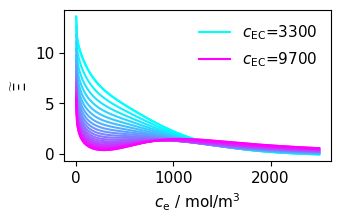

In [18]:
# plot Fun_Xi_tidle
C_e = np.linspace(1,2.5E3,300); T=298.75
c_EC_List = np.linspace(3300,9700,20).tolist()
cmap = mpl.cm.get_cmap("cool", len(c_EC_List)) 
def Plot_Xi_tidle():
    fig, axs = plt.subplots( figsize=(9/2.54,6/2.54),tight_layout=True)
    axs.plot(C_e, Fun_Xi_tidle(C_e,  c_EC_List[0] ),"-",color=cmap(0), label="$c_\mathrm{EC}$=" + f"3300")
    axs.plot(C_e, Fun_Xi_tidle(C_e,  c_EC_List[-1]),"-",color=cmap(19),label="$c_\mathrm{EC}$=" + f"9700")
    for i in range(len(c_EC_List)):
        axs.plot(C_e, Fun_Xi_tidle(C_e,  c_EC_List[i] ),"-",color=cmap(i))

    axs.set_ylabel(r"$\widetilde{\Xi}$") # $$
    #\widetilde{\Xi} = \frac{-u_{\mathrm{EC}}}{1 + X_{(\mathrm{EC,EC})}} \tag{39}$$
    #axs[i].set_ylim(-1,6)
    #axs[i].set_xlim(150,600)
    axs.set_xlabel(r"$c_\mathrm{e}$ / mol/$\mathrm{m}^3$")
    axs.legend(loc='best',frameon=False)  
    return

Plot_Xi_tidle()
if Save_fig:
    plt.savefig(Path_Fig_save + "/" +  f"Input - Xi_tilde.png", dpi=600)
    plt.savefig(Path_Fig_save + "/" +  f"Input - Xi_tilde.svg") 

#### Now we determine the diffusivities. That involves:

##### Dimensionless molarity conversion matrix $ \boldsymbol{C} $

$$
\boldsymbol{C} = \begin{bmatrix}
C_{\text{11}} & C_{\text{12}} \\
C_{\text{21}} & C_{\text{22}}
\end{bmatrix} = \begin{bmatrix}
1 + \frac{c_\text{e}}{c_0} + \frac{(\overline{V}_\text{EC} c_\text{EC})}{(\overline{V}_0 c_0)} & \frac{(\overline{V}_\text{e} - 2\overline{V}_0) c_\text{EC}}{(\overline{V}_0 c_0)} \\
\frac{(\overline{V}_\text{EC} - \overline{V}_0) c_\text{e}}{(\overline{V}_0 c_0)} & 1 + \frac{c_\text{EC}}{c_0} + \frac{(\overline{V}_\text{e} c_\text{e})}{(\overline{V}_0 c_0)}
\end{bmatrix}  \tag{33} 
$$

##### The dimensionless thermodynamic matrix $ \boldsymbol{X} $

$$
\boldsymbol{X} = \begin{bmatrix}
1 + X_\mathrm{oo} & X_\mathrm{oe} \\
X_\mathrm{eo} & 2 + X_\mathrm{ee}
\end{bmatrix}  \tag{32} 
$$


##### Thermodynamic diffusivity matrix $ \boldsymbol{\mathcal{D}} $

$$
\boldsymbol{\mathcal{D}} = \begin{bmatrix}
\mathcal{D}_o & \frac{\mathcal{D}_{\times} c_o}{c_T} \\
\frac{\mathcal{D}_{\times} c_e}{c_T} & \mathcal{D}_e
\end{bmatrix} \tag{31} 
$$


##### Fickian diffusivity matrix $ \boldsymbol{D} $

$$
\boldsymbol{D} = \begin{bmatrix}
D_{\text{EC},\text{EC}}^0 & D_{\text{EC},\text{e}}^0 \\
D_{\text{e},\text{EC}}^0 & D_{\text{ee}}^0
\end{bmatrix}  \tag{30} 
$$

##### And their relationship:
$$
\boldsymbol{D} = \boldsymbol{\mathcal{D}}\boldsymbol{XC} \tag{30} 
$$

##### Assume:

$$
D_{\text{EC},\text{EC}}^0 = 5 \times 10^{-10} \, \text{m}^2/\text{s}
$$

$$
D_{\text{ee}}^0 = 3 \times 10^{-10} \, \text{m}^2/\text{s}
$$

##### We also know the relation between the two off-diagonal element in the Fickian diffusivity matrix :

$$
D_{\text{EC},\text{e}}^0 = D_{\text{EC},\text{EC}}^0 \cdot \frac{C_{\text{12}}}{C_{\text{11}}} + 2 \frac{c_\text{EC}}{c_\text{e}} \left(\frac{C_{\text{22}}}{C_{\text{11}}} - \frac{C_{\text{12}} \cdot C_{\text{21}}}{C_{\text{11}}^2}\right) \cdot \left(D_{(\text{e},\text{EC})}^0 - \frac{\left(D_{(\text{e},\text{EC})}^0 \cdot C_{\text{12}} - D_{\text{ee}}^0 \cdot C_{\text{11}}\right) \cdot C_{\text{21}}}{C_{\text{21}} \cdot C_{\text{12}} - C_{\text{22}} \cdot C_{\text{11}}}\right)  \tag{41} 
$$

##### We can just assume $ D_{\mathrm{EC},\mathrm{EC}}^0 $ to be the "freely unknown" parameter, and use $ \det(\boldsymbol{D}) > 0 $ to determine its range. Once we get $ D_{\mathrm{EC},\mathrm{EC}}^0 $, we can use Eq. (41) to get $ D_{\text{EC},\text{e}}^0 $ and use the following equations to get the three thermodynamic diffusivities.


$$
\mathcal{D}_\mathrm{e} = \frac{D_\mathrm{e,EC}^0 \cdot C_\mathrm{12} - D_\mathrm{ee}^0 \cdot C_\mathrm{11}}{2(1 + X_\mathrm{EC,EC}) \cdot (C_\mathrm{21} \cdot C_\mathrm{12} - C_\mathrm{22} \cdot C_\mathrm{11})} \tag{38} 
$$

$$
\mathcal{D}_\mathrm{\times} = \frac{D_\mathrm{e,EC}^0}{1 + X_\mathrm{EC,EC}} - \frac{D_\mathrm{e,EC}^0 \cdot C_\mathrm{12} - D_\mathrm{ee}^0 \cdot C_\mathrm{11}}{(1 + X_\mathrm{EC,EC}) \cdot (C_\mathrm{21} \cdot C_\mathrm{12} - C_\mathrm{22} \cdot C_\mathrm{11})} \cdot \frac{c_T}{c_e \cdot C_\mathrm{11}} \tag{39} 
$$

$$
\mathcal{D}_\mathrm{EC} = \frac{D_\mathrm{EC,EC}^0}{1 + X_\mathrm{EC,EC}} - 2 \cdot \frac{c_\mathrm{EC} \cdot C_\mathrm{21}}{c_e \cdot C_\mathrm{11}} \cdot \left(\frac{D_\mathrm{e,EC}^0}{1 + X_\mathrm{EC,EC}} - \frac{D_\mathrm{e,EC}^0 \cdot C_\mathrm{12} - D_\mathrm{ee}^0 \cdot C_\mathrm{11}}{(1 + X_\mathrm{EC,EC}) \cdot (C_\mathrm{21} \cdot C_\mathrm{12} - C_\mathrm{22} \cdot C_\mathrm{11})}\right) \cdot \frac{1}{C_\mathrm{11}} \tag{40} 
$$

In [19]:
def diff_constant_3E_10(c_e, c_EC ):
    D_Li = (
        (c_EC >= 0 ) * 3e-10
        +  (c_EC < 0 ) * 3e-10 
    )
    return D_Li

def EC_diffusivity_5E_10(c_e, c_EC):
    D_ec_dim = (
        (c_EC >= 0 ) * 5e-10
        +  (c_EC < 0 ) * 0 
    )
    return D_ec_dim

In [20]:
# Now we make D_0_e_EC as an unknown, and write it as a function of D_0_e_EC
def Fun_D_0_EC_e(c_e, c_EC , D_0_e_EC):   # Eq. (41)
    # Pre-condition
    D_0_EC_EC  = 5E-10
    D_0_e_e = 3e-10
    c_T = Fun_c_T(c_e, c_EC)
    c_0 = c_T - 2*c_e - c_EC 
    C_11 = 1 + c_e/c_0 + (V_bar_EC*c_EC)/(V_bar_0*c_0)
    C_12 = (V_bar_e-2*V_bar_0)*c_EC / (V_bar_0*c_0)
    C_21 = (V_bar_EC- V_bar_0)*c_e  / (V_bar_0*c_0)
    C_22 = 1 + c_EC/c_0 + (V_bar_e*c_e)/(V_bar_0*c_0)
    D_0_EC_e = (
        D_0_EC_EC*C_12/C_11          + 
        2 * c_EC/c_e * (C_22/C_11 - C_12*C_21/(C_11*C_11)  ) * (
            D_0_e_EC -  (D_0_e_EC*C_12 - D_0_e_e*C_11)*C_21 / (C_21*C_12-C_22*C_11)     
        )
    )
    return D_0_EC_e


def Fun_det_D(c_e, c_EC , D_0_e_EC):
    D_0_EC_EC  = 5E-10
    D_0_e_e    = 3e-10
    D_0_EC_e = Fun_D_0_EC_e(c_e, c_EC , D_0_e_EC)
    det_D = D_0_e_e*D_0_EC_EC - D_0_e_EC*D_0_EC_e
    return det_D

def Fun_curly_D_e(c_e, c_EC , D_0_e_EC):   # Eq. (38)
    # Pre-condition
    D_0_EC_EC  = 5E-10
    D_0_e_e = 3e-10
    c_T = Fun_c_T(c_e, c_EC)
    c_0 = c_T - 2*c_e - c_EC 
    C_11 = 1 + c_e/c_0 + (V_bar_EC*c_EC)/(V_bar_0*c_0)
    C_12 = (V_bar_e-2*V_bar_0)*c_EC / (V_bar_0*c_0)
    C_21 = (V_bar_EC- V_bar_0)*c_e  / (V_bar_0*c_0)
    C_22 = 1 + c_EC/c_0 + (V_bar_e*c_e)/(V_bar_0*c_0)
    T  = 298.15
    X_EC_EC = Fun_X_EC_EC(c_e, c_EC )

    numerator = D_0_e_EC * C_12 - D_0_e_e * C_11
    denominator = 2 * (1 + X_EC_EC) * (C_21 * C_12 - C_22 * C_11)
    return numerator / denominator

def Fun_curly_D_x(c_e, c_EC , D_0_e_EC):
    # Pre-condition
    D_0_EC_EC  = 5E-10
    D_0_e_e = 3e-10
    c_T = Fun_c_T(c_e, c_EC)
    c_0 = c_T - 2*c_e - c_EC 
    C_11 = 1 + c_e/c_0 + (V_bar_EC*c_EC)/(V_bar_0*c_0)
    C_12 = (V_bar_e-2*V_bar_0)*c_EC / (V_bar_0*c_0)
    C_21 = (V_bar_EC- V_bar_0)*c_e  / (V_bar_0*c_0)
    C_22 = 1 + c_EC/c_0 + (V_bar_e*c_e)/(V_bar_0*c_0)
    T  = 298.15
    X_EC_EC = Fun_X_EC_EC(c_e, c_EC )

    first_term = D_0_e_EC / (1 + X_EC_EC)
    second_term_numerator = D_0_e_EC * C_12 - D_0_e_e * C_11
    second_term_denominator = (1 + X_EC_EC) * (C_21 * C_12 - C_22 * C_11)
    second_term = second_term_numerator / second_term_denominator
    return first_term - second_term * ( c_T / (c_e * C_11) )

def Fun_curly_D_EC(c_e, c_EC , D_0_e_EC):
    # Pre-condition
    D_0_EC_EC  = 5E-10
    D_0_e_e = 3e-10
    c_T = Fun_c_T(c_e, c_EC)
    c_0 = c_T - 2*c_e - c_EC 
    C_11 = 1 + c_e/c_0 + (V_bar_EC*c_EC)/(V_bar_0*c_0)
    C_12 = (V_bar_e-2*V_bar_0)*c_EC / (V_bar_0*c_0)
    C_21 = (V_bar_EC- V_bar_0)*c_e  / (V_bar_0*c_0)
    C_22 = 1 + c_EC/c_0 + (V_bar_e*c_e)/(V_bar_0*c_0)
    T  = 298.15
    X_EC_EC = Fun_X_EC_EC(c_e, c_EC )

    first_term = D_0_EC_EC / (1 + X_EC_EC)
    second_term_numerator = D_0_e_EC * C_12 - D_0_e_e * C_11
    second_term_denominator = (1 + X_EC_EC) * (C_21 * C_12 - C_22 * C_11)
    second_term = 2 * (c_EC * C_21) / (c_e * C_11) * ( 
        D_0_e_EC / (1 + X_EC_EC)   - 
        second_term_numerator / second_term_denominator)
    return first_term - second_term / C_11



##### We have got the range for $ D_{\mathrm{e},\mathrm{EC}}^0 $ in Case_3_Para.ipynb to be [-1e-11, 1.5e-11]. 

##### In this work, we assume three values of $ D_{\text{e},\text{EC}}^0 $: 0, 1.5E-11 m2/s. Now we have a look at what the remaining 4 diffusivities looks like.


/tmp/ipykernel_11462/3656429390.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("cool", len(c_EC_List))


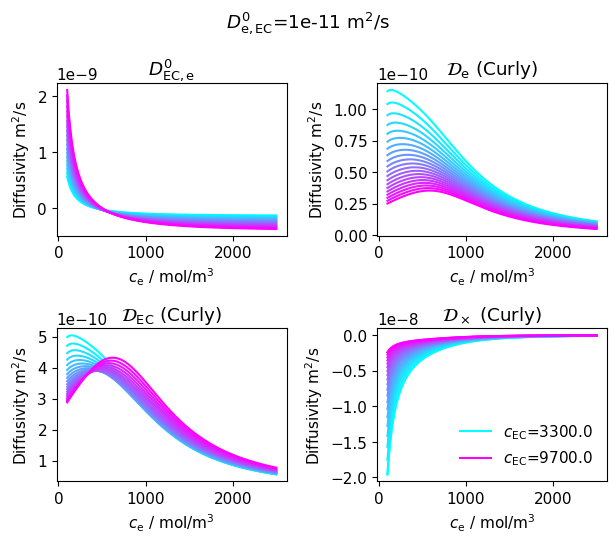

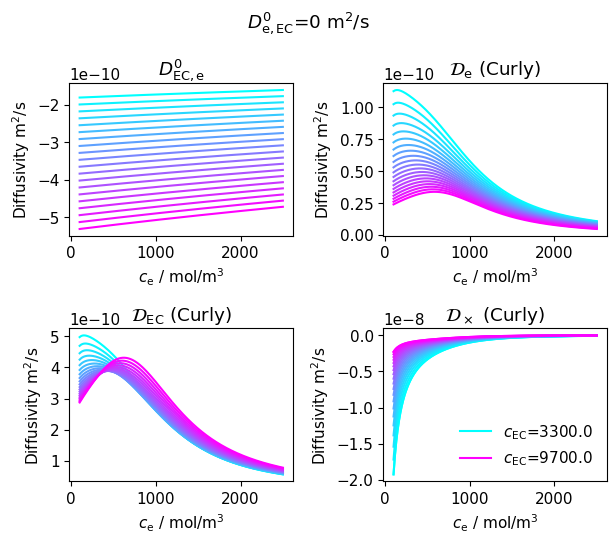

In [21]:
# Fun_D_0_EC_e, Fun_curly_D_e, Fun_curly_D_e, Fun_curly_D_x, Fun_curly_D_EC
fs=11; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
cmap = mpl.cm.get_cmap("cool", len(c_EC_List)) 
def Plot_4_Diff(D_0_e_EC):
    C_e = np.linspace(100,2.5E3,300); T=298.75
    c_EC_List = np.linspace(3300,9700,20).tolist()
    Titiles = [
        r'$ D_{\mathrm{EC},\mathrm{e}}^0$',
        r'$\mathcal{D}_\mathrm{e}$ (Curly)',
        r'$\mathcal{D}_\mathrm{EC}$ (Curly)',
        r'$\mathcal{D}_\times$ (Curly)',
    ]
    # (c_e, c_EC , D_0_e_EC)
    fig, axss = plt.subplots(2,2, figsize=(16/2.54,14/2.54),tight_layout=True)
    axs   = axss.flatten()
    # C_e = C_e/1e3; c_EC_List = [c_EC/1e3 for c_EC in c_EC_List]
    axs[3].plot(C_e, Fun_curly_D_x(C_e,  c_EC_List[0] , D_0_e_EC),"-",color=cmap(0), label="$c_\mathrm{EC}$=" + f"{c_EC_List[0]}")
    axs[3].plot(C_e, Fun_curly_D_x(C_e,  c_EC_List[-1] ,D_0_e_EC),"-",color=cmap(19),label="$c_\mathrm{EC}$=" + f"{c_EC_List[-1]}")
    for i in range(len(c_EC_List)):
        axs[0].plot(C_e, Fun_D_0_EC_e(C_e,  c_EC_List[i] , D_0_e_EC),"-",color=cmap(i))
        axs[1].plot(C_e, Fun_curly_D_e(C_e, c_EC_List[i] , D_0_e_EC),"-",color=cmap(i))
        axs[2].plot(C_e, Fun_curly_D_EC(C_e,  c_EC_List[i] , D_0_e_EC),"-",color=cmap(i))
        axs[3].plot(C_e, Fun_curly_D_x(C_e, c_EC_List[i] , D_0_e_EC),"-",color=cmap(i))

    for i in range(4): 
        axs[i].set_xlabel(r"$c_\mathrm{e}$ / $\mathrm{mol/m^3}$")
        axs[i].set_ylabel(r'Diffusivity $\mathrm{m}^2/\mathrm{s}$')
        axs[i].set_title(Titiles[i])
    axs[3].legend(loc='best',frameon=False)  
    fig.suptitle(r"$D_\mathrm{e,EC}^\mathrm{0}$"+f"={D_0_e_EC}"+r" m$^2$/s")
    if Save_fig:
        plt.savefig(Path_Fig_save + "/" +  f"Four diffusivities when D_0_e,EC={D_0_e_EC}.png", dpi=600)
        plt.savefig(Path_Fig_save + "/" +  f"Four diffusivities when D_0_e,EC={D_0_e_EC}.svg") 
    return

Plot_4_Diff(D_0_e_EC = 1E-11)
Plot_4_Diff(D_0_e_EC = 0)

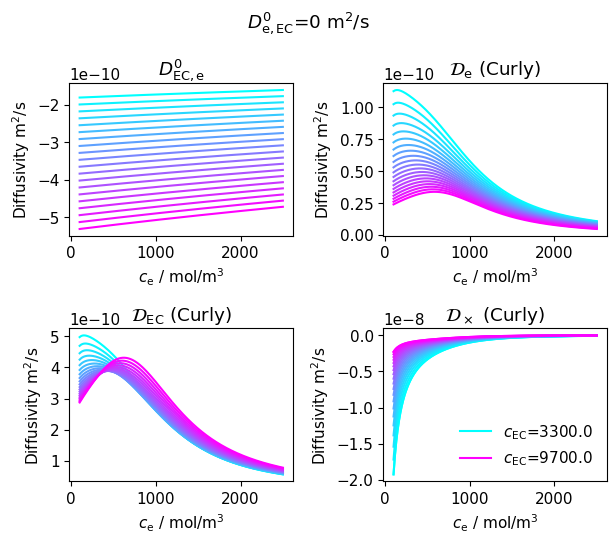

In [22]:
Plot_4_Diff(D_0_e_EC = 0)

/tmp/ipykernel_11462/1297255620.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("cool", len(c_EC_List))


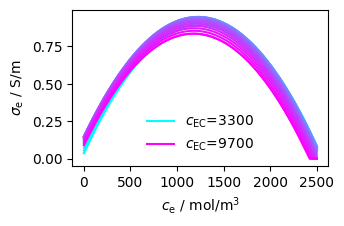

In [29]:
# Ionic conductivity from Wang 2022
def electrolyte_conductivity_Andrew2022(x,y):# x:c_Li+,y:c_ec
    p00 =     -0.2524;
    p10 =    0.001402;
    p01 =   0.0001142 ;
    p20 =  -5.379e-07  ;
    p11 =  -1.399e-08 ;
    p02 =  -8.137e-09  ;
    kai  = (
        (x > 0 )  *(
        (p00 + p10*x + p01*y + p20*x*x + p11*x*y + p02*y*y)
        + (x <= 0 ) * 0 )
    )
    kai_final = (kai>0) * kai + (kai<0) * 0
    return kai_final

C_e = np.linspace(1,2.5E3,300); T=298.75
c_EC_List = np.linspace(3300,9700,20).tolist()
cmap = mpl.cm.get_cmap("cool", len(c_EC_List)) 
def Plot_kai():
    fig, axs = plt.subplots( figsize=(9/2.54,6/2.54),tight_layout=True)
    axs.plot(C_e, electrolyte_conductivity_Andrew2022(C_e,  c_EC_List[0] ),"-",color=cmap(0), label="$c_\mathrm{EC}$=" + f"3300")
    axs.plot(C_e, electrolyte_conductivity_Andrew2022(C_e,  c_EC_List[-1]),"-",color=cmap(19),label="$c_\mathrm{EC}$=" + f"9700")
    for i in range(len(c_EC_List)):
        axs.plot(C_e, electrolyte_conductivity_Andrew2022(C_e,  c_EC_List[i] ),"-",color=cmap(i))

    axs.set_ylabel(r"$\sigma_\mathrm{e}$ / S/m")
    #\widetilde{\Xi} = \frac{-u_{\mathrm{EC}}}{1 + X_{(\mathrm{EC,EC})}} \tag{39}$$
    #axs[i].set_ylim(-1,6)
    #axs[i].set_xlim(150,600)
    axs.set_xlabel(r"$c_\mathrm{e}$ / mol/$\mathrm{m}^3$")
    axs.legend(loc='best',frameon=False)  
    return

Plot_kai()
if Save_fig:
    plt.savefig(Path_Fig_save + "/" +  f"Input - electrolyte_conductivity_Andrew2022.png", dpi=600)
    plt.savefig(Path_Fig_save + "/" +  f"Input - electrolyte_conductivity_Andrew2022.svg") 


#### Now we can finally plot out all the parameters (8 in main text, 12 in SI):


In [24]:
diff_constant_3E_10(C_e,c_EC_1_specie)

3e-10

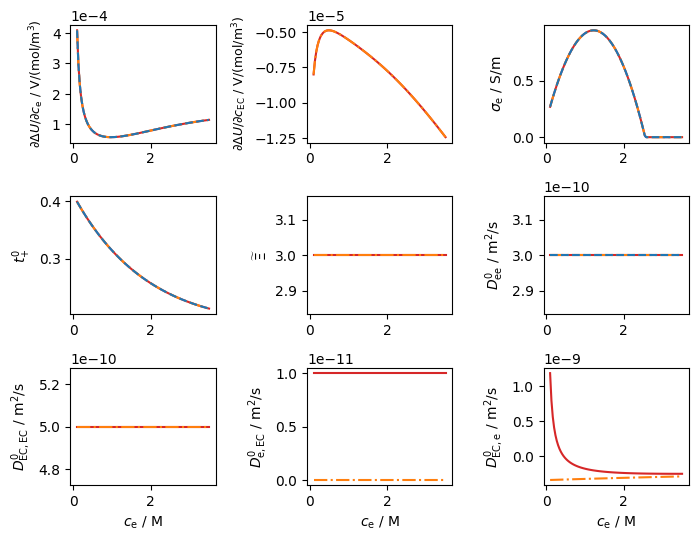

In [30]:
# Plot all 8 or 9 parameters used in model (Explicitly)
fs=10; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
import os
Colors = ['#1f77b4','#ff7f0e',  '#d62728', ]; # single, double - low, double-high
LS = ['--','-.','-',]
Labels = ["Single",r"Double-Low $D_\mathrm{e,EC}^\mathrm{0}$",r"Double-High $D_\mathrm{e,EC}^\mathrm{0}$"]
def Plot_All_8_Para(D_0_e_EC,Save_fig):
    """ Function to look: 
    # electrolyte_conductivity_Andrew2022(c_e,c_EC)
    # Fun_t_0plus_Wang2021(c_e,c_EC)
    # dLJP_2_Species_dc_e_np(c_e,c_EC)
    # dLJP_2_Species_dc_EC_np(c_e,c_EC)
    # dLJP_1_Specie_dc_e_np(c_e)
    # Fun_Xi_tidle(c_e,c_EC)
    # diff_constant_3E_10(c_e, c_EC )
    # EC_diffusivity_5E_10(c_e, c_EC)
    # Fun_D_0_EC_e """
    fig, axss = plt.subplots(
        3,3, figsize=(18/2.54,14/2.54),tight_layout=True)
    axs   = axss.flatten()
    # get c range:  # When c_e=1000 mol/m3, c_EC=5622.86, c_T=13245.72 mol/m3
    c_EC_1_specie = 6209.49; C_EC = np.linspace(1E3,1E4,300).tolist();   
    C_e = np.linspace(100,3.5E3,100) # .tolist()
    # first: dLJP_2_Species_dc_e_np and dLJP_1_Specie_dc_e_np
    axs[0].plot(C_e/1e3,dLJP_2_Species_dc_e_np(C_e,c_EC_1_specie),linestyle=LS[2],label=Labels[2],color=Colors[2])
    axs[0].plot(C_e/1e3,dLJP_2_Species_dc_e_np(C_e,c_EC_1_specie),linestyle=LS[1],label=Labels[1],color=Colors[1])
    axs[0].plot(C_e/1e3,dLJP_2_Species_dc_e_np(C_e,c_EC_1_specie),linestyle=LS[0],label=Labels[0],color=Colors[0])
    axs[0].set_ylabel(
        r'$\partial \Delta U / \partial c_\mathrm{e}$ / $\mathrm{V/(mol/m^3)}$',
        fontsize=fs-1)
    # second: dLJP_2_Species_dc_EC_np
    axs[1].plot(C_e/1e3,dLJP_2_Species_dc_EC_np(C_e,c_EC_1_specie),linestyle=LS[2],label=Labels[2],color=Colors[2])
    axs[1].plot(C_e/1e3,dLJP_2_Species_dc_EC_np(C_e,c_EC_1_specie),linestyle=LS[1],label=Labels[1],color=Colors[1])
    axs[1].set_ylabel(
        r'$\partial \Delta U / \partial c_\mathrm{EC}$ / $\mathrm{V/(mol/m^3)}$', 
        fontsize=fs-1)
    for i in range(2):
        axs[i].ticklabel_format( 
            axis='y', style='sci',scilimits=[-0.01,0.01], 
            useOffset=None, useLocale=None, useMathText=None)
    # 3rd: electrolyte_conductivity_Andrew2022
    axs[2].plot(C_e/1e3, electrolyte_conductivity_Andrew2022(C_e,c_EC_1_specie),linestyle=LS[2],label=Labels[2],color=Colors[2]) 
    axs[2].plot(C_e/1e3, electrolyte_conductivity_Andrew2022(C_e,c_EC_1_specie),linestyle=LS[1],label=Labels[1],color=Colors[1]) 
    axs[2].plot(C_e/1e3, electrolyte_conductivity_Andrew2022(C_e,c_EC_1_specie),linestyle=LS[0],label=Labels[0],color=Colors[0]) 
    axs[2].set_ylabel("$\sigma_\mathrm{e}$ / S/m")
    # 4th: Fun_t_0plus_Wang2021
    axs[3].plot(C_e/1e3, Fun_t_0plus_Wang2021(C_e,c_EC_1_specie),linestyle=LS[2],label=Labels[2],color=Colors[2]) 
    axs[3].plot(C_e/1e3, Fun_t_0plus_Wang2021(C_e,c_EC_1_specie),linestyle=LS[1],label=Labels[1],color=Colors[1]) 
    axs[3].plot(C_e/1e3, Fun_t_0plus_Wang2021(C_e,c_EC_1_specie),linestyle=LS[0],label=Labels[0],color=Colors[0]) 
    axs[3].set_ylabel(r'$t_{+}^{0}$')
    # 5rd: Fun_Xi_tidle
    axs[4].plot(C_e/1e3, np.ones(np.size(C_e))*3, linestyle=LS[2],label=Labels[2],color=Colors[2]) # Fun_Xi_tidle(C_e,c_EC_1_specie)
    axs[4].plot(C_e/1e3, np.ones(np.size(C_e))*3, linestyle=LS[1],label=Labels[1],color=Colors[1]) 
    axs[4].set_ylabel(r"$\widetilde{\Xi}$") # $$
    # 6-9: D_ee, D_EC,EC, D_e,EC, D_EC,e 
    axs[5].plot(C_e/1e3, np.ones(np.size(C_e))*3e-10,linestyle=LS[2],label=Labels[2],color=Colors[2])
    axs[5].plot(C_e/1e3, np.ones(np.size(C_e))*3e-10,linestyle=LS[1],label=Labels[1],color=Colors[1])
    axs[5].plot(C_e/1e3, np.ones(np.size(C_e))*3e-10,linestyle=LS[0],label=Labels[0],color=Colors[0])
    axs[5].set_ylabel(r"$D_\mathrm{ee}^\mathrm{0}$ / $\mathrm{m}^2/\mathrm{s}$")
    axs[6].plot(C_e/1e3, np.ones(np.size(C_e))*5e-10,linestyle=LS[2],label=Labels[2],color=Colors[2])
    axs[6].plot(C_e/1e3, np.ones(np.size(C_e))*5e-10,linestyle=LS[1],label=Labels[1],color=Colors[1])
    axs[6].set_ylabel(r"$D_\mathrm{EC,EC}^\mathrm{0}$ / $\mathrm{m}^2/\mathrm{s}$")
    # D_0_e_EC = 1.5e-11
    axs[7].plot(
        C_e/1e3, np.ones(np.size(C_e))*D_0_e_EC,linestyle=LS[2],label=Labels[2],color=Colors[2])
    axs[7].plot(
        C_e/1e3, np.zeros(np.size(C_e)),linestyle=LS[1],label=Labels[1],color=Colors[1])
    axs[7].set_ylabel(r"$D_\mathrm{e,EC}^\mathrm{0}$ / $\mathrm{m}^2/\mathrm{s}$")

    axs[8].plot(
        C_e/1e3, Fun_D_0_EC_e(C_e,c_EC_1_specie,D_0_e_EC),
        linestyle=LS[2],label=Labels[2],color=Colors[2])
    axs[8].plot(
        C_e/1e3, Fun_D_0_EC_e(C_e,c_EC_1_specie,0),
        linestyle=LS[1],label=Labels[1],color=Colors[1])
    # axs[0].legend(prop={'family':'DejaVu Sans','size':fs-1},loc='best',frameon=False)  
    axs[8].set_ylabel(r"$D_\mathrm{EC,e}^\mathrm{0}$ / $\mathrm{m}^2/\mathrm{s}$")
    for i in [6,7,8]:
        axs[i].set_xlabel(r"$c_\mathrm{e}$ / $\mathrm{M}$")
    if Save_fig:
        plt.savefig(Path_Fig_save + "/" +  f"All 9 parameters for D_0_e_EC=0 or {D_0_e_EC}, c_EC=6209.png", dpi=600)
        plt.savefig(Path_Fig_save + "/" +  f"All 9 parameters for D_0_e_EC=0 or {D_0_e_EC}, c_EC=6209.svg") 
    return 
Plot_All_8_Para(D_0_e_EC=1e-11,Save_fig=True)

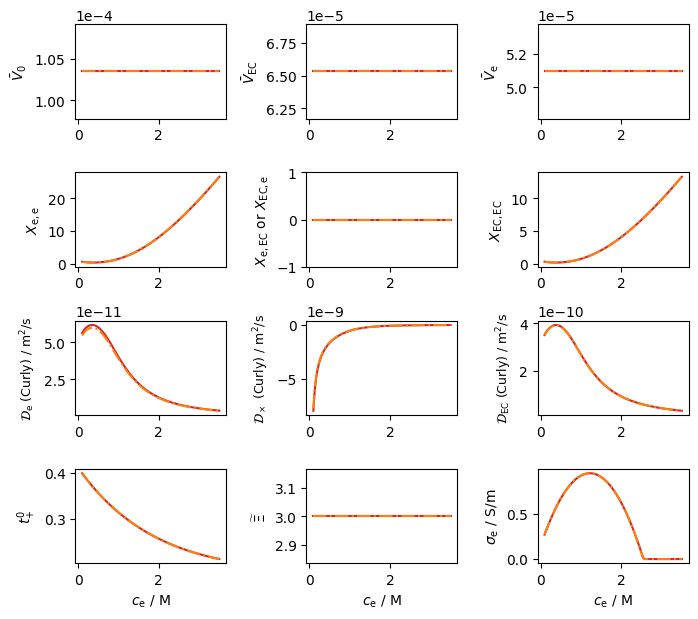

In [31]:
# Plot all 12 Fundamental parameters in model (Implicitly)
fs=10; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
def Plot_All_12_Para(D_0_e_EC,Save_fig):
    """ Function to look: 
    # X_e,EC = x_EC,e=0 ;  Fun_X_e_e(c_e,c_EC) Fun_X_EC_EC(c_e,c_EC)
    # electrolyte_conductivity_Andrew2022(c_e,c_EC)
    # Fun_t_0plus_Wang2021(c_e,c_EC)
    # Fun_Xi_tidle(c_e,c_EC)
    # Fun_curly_D_e(c_e, c_EC , D_0_e_EC)
    # Fun_curly_D_x   ; Fun_curly_D_EC
    """
    V_bar_zero = 1.0347e-04 # m3/mol
    V_bar_o= 6.5312e-05 # m3/mol
    V_bar_e = 5.0943e-05 # m3/mol

    fig, axss = plt.subplots(
        4,3, figsize=(18/2.54,16/2.54),tight_layout=True)
    axs   = axss.flatten()
    # get c range:  # When c_e=1000 mol/m3, c_EC=5622.86, c_T=13245.72 mol/m3
    c_EC_1_specie = 6209.49; C_EC = np.linspace(1E3,1E4,300).tolist();   
    C_e = np.linspace(100,3.5E3,100) # .tolist()
    axs[0].plot(C_e/1e3,np.ones(np.size(C_e))*V_bar_zero,linestyle=LS[2],label=Labels[2],color=Colors[2])
    axs[0].plot(C_e/1e3,np.ones(np.size(C_e))*V_bar_zero,linestyle=LS[1],label=Labels[1],color=Colors[1])
    axs[0].set_ylabel(r"$\bar{V}_0$")
    axs[1].plot(C_e/1e3,np.ones(np.size(C_e))*V_bar_o,linestyle=LS[2],label=Labels[2],color=Colors[2])
    axs[1].plot(C_e/1e3,np.ones(np.size(C_e))*V_bar_o,linestyle=LS[1],label=Labels[1],color=Colors[1])
    axs[1].set_ylabel(r"$\bar{V}_\mathrm{EC}$") 
    for i in range(2):
        axs[i].ticklabel_format( 
            axis='y', style='sci',scilimits=[-0.01,0.01], 
            useOffset=None, useLocale=None, useMathText=None)
    axs[2].plot(C_e/1e3,np.ones(np.size(C_e))*V_bar_e,linestyle=LS[2],label=Labels[2],color=Colors[2])
    axs[2].plot(C_e/1e3,np.ones(np.size(C_e))*V_bar_e,linestyle=LS[1],label=Labels[1],color=Colors[1])
    axs[2].set_ylabel(r"$\bar{V}_\mathrm{e}$") 

    axs[3].plot(C_e/1e3, Fun_X_e_e(C_e,c_EC_1_specie),linestyle=LS[2],label=Labels[2],color=Colors[2] ) 
    axs[3].plot(C_e/1e3, Fun_X_e_e(C_e,c_EC_1_specie),linestyle=LS[1],label=Labels[1],color=Colors[1] ) 
    axs[3].set_ylabel(r"$ X_\mathrm{e,e} $")
    axs[4].plot(C_e/1e3,np.zeros(np.size(C_e)),linestyle=LS[2],label=Labels[2],color=Colors[2]) # X_eo or X_oe
    axs[4].plot(C_e/1e3,np.zeros(np.size(C_e)),linestyle=LS[1],label=Labels[1],color=Colors[1]) # X_eo or X_oe
    axs[4].set_ylabel(r"$ X_\mathrm{e,EC} $ or $ X_\mathrm{EC,e} $")
    axs[4].set_ylim([-1,1])
    axs[5].plot(C_e/1e3, Fun_X_EC_EC(C_e,c_EC_1_specie),linestyle=LS[2],label=Labels[2],color=Colors[2] ) 
    axs[5].plot(C_e/1e3, Fun_X_EC_EC(C_e,c_EC_1_specie),linestyle=LS[1],label=Labels[1],color=Colors[1] ) 
    axs[5].set_ylabel(r"$ X_\mathrm{EC,EC} $")

    axs[6].plot(C_e/1e3, Fun_curly_D_e(C_e,c_EC_1_specie, D_0_e_EC),linestyle=LS[2],label=Labels[2],color=Colors[2] )
    axs[7].plot(C_e/1e3, Fun_curly_D_x(C_e,c_EC_1_specie, D_0_e_EC),linestyle=LS[2],label=Labels[2],color=Colors[2] )
    axs[8].plot(C_e/1e3, Fun_curly_D_EC(C_e,c_EC_1_specie, D_0_e_EC),linestyle=LS[2],label=Labels[2],color=Colors[2] )
    axs[6].plot(C_e/1e3, Fun_curly_D_e(C_e,c_EC_1_specie, 0), linestyle=LS[1],label=Labels[1],color=Colors[1])
    axs[7].plot(C_e/1e3, Fun_curly_D_x(C_e,c_EC_1_specie, 0), linestyle=LS[1],label=Labels[1],color=Colors[1] )
    axs[8].plot(C_e/1e3, Fun_curly_D_EC(C_e,c_EC_1_specie, 0),linestyle=LS[1],label=Labels[1],color=Colors[1] )
    axs[6].set_ylabel(r'$\mathcal{D}_\mathrm{e}$ (Curly) / $\mathrm{m}^2/\mathrm{s}$',fontsize=fs-1)
    axs[7].set_ylabel(r'$\mathcal{D}_\times$ (Curly) / $\mathrm{m}^2/\mathrm{s}$',fontsize=fs-1)
    axs[8].set_ylabel(r'$\mathcal{D}_\mathrm{EC}$ (Curly) / $\mathrm{m}^2/\mathrm{s}$',fontsize=fs-1)

    axs[9].plot(C_e/1e3, Fun_t_0plus_Wang2021(C_e,c_EC_1_specie),linestyle=LS[2],label=Labels[2],color=Colors[2] ) 
    axs[9].plot(C_e/1e3, Fun_t_0plus_Wang2021(C_e,c_EC_1_specie),linestyle=LS[1],label=Labels[1],color=Colors[1] ) 
    axs[9].set_ylabel(r'$t_{+}^{0}$')

    axs[10].plot(C_e/1e3, np.ones(np.size(C_e))*3, linestyle=LS[2],label=Labels[2],color=Colors[2]) # Fun_Xi_tidle(C_e,c_EC_1_specie)
    axs[10].plot(C_e/1e3, np.ones(np.size(C_e))*3, linestyle=LS[1],label=Labels[1],color=Colors[1]) 
    axs[10].set_ylabel(r"$\widetilde{\Xi}$") # $$

    axs[11].plot(C_e/1e3, electrolyte_conductivity_Andrew2022(C_e,c_EC_1_specie), linestyle=LS[2],label=Labels[2],color=Colors[2]) 
    axs[11].plot(C_e/1e3, electrolyte_conductivity_Andrew2022(C_e,c_EC_1_specie), linestyle=LS[1],label=Labels[1],color=Colors[1]) 
    axs[11].set_ylabel("$\sigma_\mathrm{e}$ / S/m")
    
    for i in [9,10,11,]:
        axs[i].set_xlabel(r"$c_\mathrm{e}$ / $\mathrm{M}$")
    if Save_fig:
        plt.savefig(Path_Fig_save + "/" +  f"All 12 parameters for D_0_e_EC=0 or {D_0_e_EC}, c_EC=6209.png", dpi=600)
        plt.savefig(Path_Fig_save + "/" +  f"All 12 parameters for D_0_e_EC=0 or {D_0_e_EC}, c_EC=6209.svg") 
    return 
Plot_All_12_Para(D_0_e_EC=1.0e-11,Save_fig=True)

#### To ensure the model result is plausible, it is important not to exceed the expeirment range of concentration (avoid extrapolation). Base on Jung 2023, we need to apply the constrains:
$$ 0 < y_\mathrm{EC} < 0.75 $$
$$ 0.002 < y_\mathrm{e} < 0.15 $$

##### for one species, we need to constrain that $ y_\mathrm{0}=y_\mathrm{EC} (c_0=c_\mathrm{EC}) $, then $ 0.002< y_\mathrm{e} <0.15 $. In this case, we can write the expression of $y_\mathrm{e}$ in terms of $c_\mathrm{e}$ then get the range for $c_\mathrm{e}$. Based on the below calculation, the range for $y_\mathrm{e}$ should be:

$$ 24.22 < c_\mathrm{e} < 2286.54 \quad \mathrm{Unit: mol/m^3}  $$

##### Note that this range only apply for the measured liquid junction potentoal and dervied parameters, 

In [27]:
# Calculate typical concentration: 1M LiPF6 in EMC:EC=1:1 wt%, 
from sympy import symbols, Eq, solve
m_bar_EC = 88.062*1e-3  #   kg/mol
m_bar_0  = 104.105*1e-3 #   kg/mol

c_e,c_EC = symbols("c_e c_EC",real=True)
c_0 = Fun_c_T(c_e, c_EC) - 2*c_e - c_EC
Eq_1 =Eq(c_0*m_bar_0 ,c_EC*m_bar_EC)        # mass_ratio  =  [(c * V) * molar_mass] : [(c * V) * molar_mass]
c_EC_0 = solve(Eq_1,c_EC)
print(c_EC_0)
y_e = c_e / Fun_c_T(c_e, c_EC_0[0]) 

c_e_1 = solve(Eq(y_e ,0.002),c_e)
c_e_2 = solve(Eq(y_e ,0.15),c_e)
print(f"For one species assumption, EMC:EC=1:1, when 0.002<y_e<0.15,"
      f" c_e should be: {c_e_1[0]:.2f}<c_e<{c_e_2[0]:.2f} mol/m3")


# when c_e = 1000:
c_e_1000 = 1000; c_EC_1000 = c_EC_0[0].subs({c_e:1000});
c_0_1000 = c_EC_1000 * m_bar_EC / m_bar_0
c_T_1000 = 2*c_e_1000 + c_EC_1000 + c_0_1000
print(f"When c_e={c_e_1000} mol/m3, c_EC={c_EC_1000:.2f}, c_0={c_0_1000:.2f},"
      f" c_T={c_T_1000:.2f} mol/m3")

[6542.79764002435 - 0.333307674099918*c_e]
For one species assumption, EMC:EC=1:1, when 0.002<y_e<0.15, c_e should be: 24.22<c_e<2286.54 mol/m3
When c_e=1000 mol/m3, c_EC=6209.49, c_0=5252.58, c_T=13462.07 mol/m3


#### For the double species, it is a bit tricky to determine ranges for 2 variables, so just keep an eye during post-processing. Despite this issue, we can still get a range of the experimental measured c_e and c_EC

In [28]:
13245.72 - 2000 - 5622.86

5622.86

#### Now we should have all parameters determined, just need to calculate the remaining and then make them compatable with PyBaMM